<a href="https://colab.research.google.com/github/Ibrah-N/Deep-Learning-Projects-Computer-Vision/blob/main/dl_21_clothes_plugins_image_segmentation_with_segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & Configs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", wh

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os

import tensorflow as tf

## Data Preprocessing

### Downlaoding Dataset

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rajkumarl/people-clothing-segmentation
!unzip -q people-clothing-segmentation.zip -d dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation
License(s): CC0-1.0
100% 614M/616M [00:11<00:00, 87.3MB/s]
100% 616M/616M [00:11<00:00, 54.5MB/s]


In [4]:
# configuration
BATCH_SIZE = 8
EPOCHS = 35
LR = 0.000001
WEIGHT_DECAY_RATE = 0.01

### Extracting Images & Masks Paths

In [5]:
TRAIN_IMG_PATHS = "/content/dataset/png_images/IMAGES/"
TRAIN_MASK_PATHS = "/content/dataset/png_masks/MASKS/"
VAL_IMG_PATHS = "/content/val_dataset/png_images/IMAGES/"
VAL_MASK_PATHS = "/content/val_dataset/png_masks/MASKS/"

In [6]:
!mkdir /content/val_dataset
!mkdir /content/val_dataset/png_images
!mkdir /content/val_dataset/png_masks
!mkdir /content/val_dataset/png_images/IMAGES
!mkdir /content/val_dataset/png_masks/MASKS

In [7]:
VAL_LIST = ["0018", '0026', '0016', '0213', '0225', '0312',
            '0344', '0356', '0399', '0401', '0411', '0434',
            '0511', '0520', '0545', '0555', '0577', '0612']

In [8]:
for i in VAL_LIST:
    shutil.move(TRAIN_IMG_PATHS+"img_"+i+'.png', VAL_IMG_PATHS+"img_"+i+'.png')
    shutil.move(TRAIN_MASK_PATHS+"seg_"+i+'.png', VAL_MASK_PATHS+"img_"+i+'.png')

In [9]:
for i in os.listdir(TRAIN_MASK_PATHS):
  shutil.os.rename(TRAIN_MASK_PATHS+i, TRAIN_MASK_PATHS+"img"+i[3:])

### Load Images & Masks

In [10]:
t_dataset = tf.data.Dataset.from_tensor_slices(
    ([TRAIN_IMG_PATHS+i for i in os.listdir(TRAIN_IMG_PATHS)],
     [TRAIN_MASK_PATHS+i for i in os.listdir(TRAIN_IMG_PATHS)])
)
for i, j in t_dataset.take(2):
  print(i, j)
print(f"files loaded : {len(t_dataset)}")

tf.Tensor(b'/content/dataset/png_images/IMAGES/img_0728.png', shape=(), dtype=string) tf.Tensor(b'/content/dataset/png_masks/MASKS/img_0728.png', shape=(), dtype=string)
tf.Tensor(b'/content/dataset/png_images/IMAGES/img_0969.png', shape=(), dtype=string) tf.Tensor(b'/content/dataset/png_masks/MASKS/img_0969.png', shape=(), dtype=string)
files loaded : 982


In [11]:
v_dataset =  tf.data.Dataset.from_tensor_slices(
    ([VAL_IMG_PATHS+i for i in os.listdir(VAL_IMG_PATHS)],
     [VAL_MASK_PATHS+i for i in os.listdir(VAL_IMG_PATHS)])
)
for i, j in v_dataset.take(2):
  print(i, j)
print(f"files loaded : {len(v_dataset)}")

tf.Tensor(b'/content/val_dataset/png_images/IMAGES/img_0612.png', shape=(), dtype=string) tf.Tensor(b'/content/val_dataset/png_masks/MASKS/img_0612.png', shape=(), dtype=string)
tf.Tensor(b'/content/val_dataset/png_images/IMAGES/img_0434.png', shape=(), dtype=string) tf.Tensor(b'/content/val_dataset/png_masks/MASKS/img_0434.png', shape=(), dtype=string)
files loaded : 18


In [12]:
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]

def load_imgs_masks(img_path, mask_path):
  img = tf.io.decode_jpeg(tf.io.read_file(img_path))
  mask = tf.io.decode_jpeg(tf.io.read_file(mask_path))

  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  mask = tf.image.convert_image_dtype(
      tf.squeeze(mask, axis=-1), dtype=tf.float32 )

  return (img-MEAN)/STD, mask

In [13]:
pre_train_dataset = (
    t_dataset
    .map(load_imgs_masks)
    .shuffle(10)
)

pre_val_dataset = (
    v_dataset
    .map(load_imgs_masks)
)

In [14]:
for i, j in pre_train_dataset.take(1):
  print(i.shape, j.shape)

(825, 550, 3) (825, 550)


### Visualization Before Augmentation

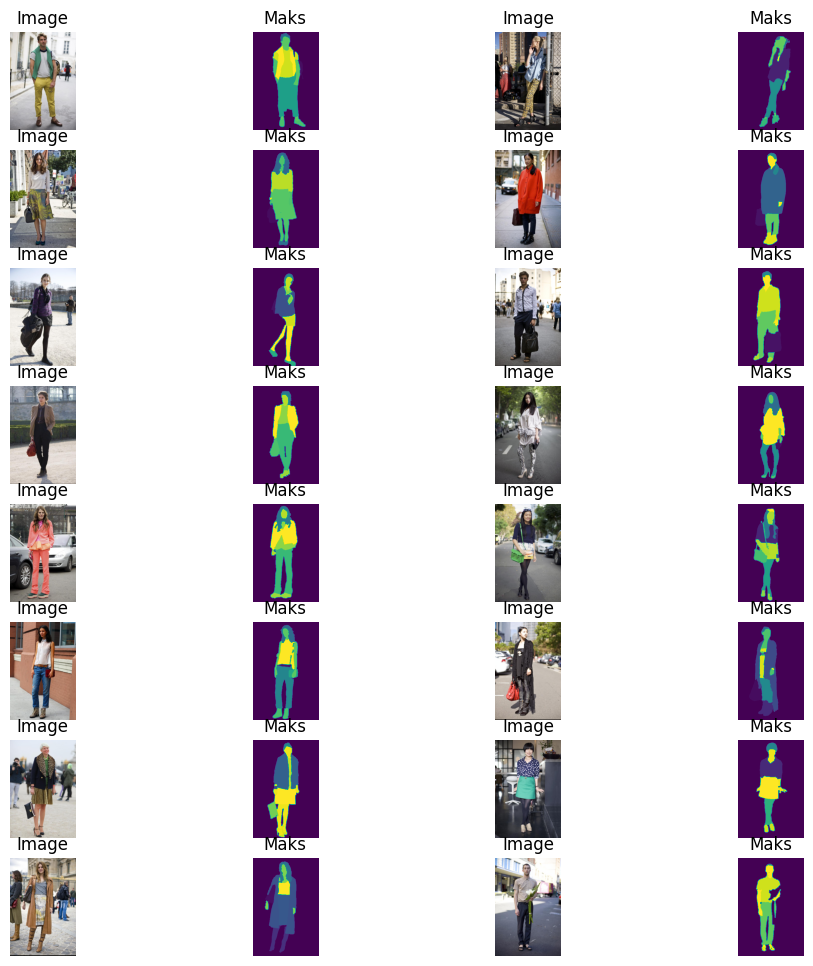

In [ ]:
n_row = 8
n_col = 4
row = 0
col = 0
_, ax = plt.subplots(n_row, n_col, figsize=(12, 12))
for img, mask in pre_train_dataset.batch(16).take(1):

  for i in range(n_row * n_col):

    if i%2 == 0:
      ax[row, col].imshow(img[i//2]*STD+MEAN)
      ax[row, col].axis("off")
      ax[row, col].set_title("Image")
    else:
      ax[row, col].imshow(mask[i//2])
      ax[row, col].axis("off")
      ax[row, col].set_title("Maks")

    if col == n_col-1:
      row += 1
      col = 0
    else:
      col += 1


plt.show()

### Visualization-2

In [ ]:
!pip install -q fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.9/942.9 kB 57.5 MB/s eta 0:00:

In [ ]:
import fiftyone as fo

In [ ]:
name = "Clothe-Image-4"
data_path = "/content/dataset/png_images/IMAGES"
labels_path = "/content/dataset/png_masks/MASKS"

# Import dataset by explicitly providing paths to the source media and masks
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.ImageSegmentationDirectory,
    data_path=data_path,
    labels_path=labels_path,
    name=name,
)

Migrating database to v0.24.1


INFO:fiftyone.migrations.runner:Migrating database to v0.24.1


 100% |█████████████████| 982/982 [599.2ms elapsed, 0s remaining, 1.7K samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 982/982 [599.2ms elapsed, 0s remaining, 1.7K samples/s]      


In [ ]:
print(dataset)
print(dataset.head())

Name:        Clothe-Image-4
Media type:  image
Num samples: 982
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)
[<Sample: {
    'id': '66b2c5d7d0909da748808221',
    'media_type': 'image',
    'filepath': '/content/dataset/png_images/IMAGES/img_0001.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentation: {
        'id': '66b2c5d7d0909da748808220',
        'tags': [],
        'mask': None,
        'mask_path': '/content/dataset/png_masks/MASKS/img_0001.png',
    }>,
}>, <Sample: {
    'id': '66b2c5d7d0909da748808228',
    'media_type': 'image',
    'filepath': '/content/dataset/png_image

In [ ]:
session = fo.launch_app(dataset)


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



### Data Augmentation

In [15]:
!pip install -q albumentations

In [16]:
import albumentations as A

In [17]:
H, W = 512, 512

In [18]:
transform = A.Compose([
    A.RandomCrop(width=W, height=H, p=1.0),
    A.HorizontalFlip(p=0.1),
    A.VerticalFlip(p=0.1),
    # A.RandomBrightnessContrast(p=0.2),
    A.Transpose(p=0.2),
])

val_transform = A.Compose([
    A.Resize(height=H, width=W, p=1.0)
])

In [19]:
def aug_albument(image, mask):
  augmented = transform(image=image, mask=mask)
  return [
      tf.convert_to_tensor(augmented["image"], dtype=tf.float32),
      tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

def val_aug_albument(image, mask):
  val_augmented = val_transform(image=image, mask=mask)
  return [
      tf.convert_to_tensor(val_augmented["image"], dtype=tf.float32),
      tf.convert_to_tensor(val_augmented["mask"], dtype=tf.float32)]

In [20]:
# H W C
# 0 1 2
#---> CONVERT INTO
# C H W
# 2 0 1

def aug_function(image, mask):
  augmented_out = tf.numpy_function(func=aug_albument, inp=[image, mask], Tout=[tf.float32, tf.float32])
  return {
      "pixel_values": tf.transpose(augmented_out[0], [2, 0, 1]),
      "labels": augmented_out[1]}

def val_aug_function(image, mask):
  val_augmented_out = tf.numpy_function(func=val_aug_albument, inp=[image, mask], Tout=[tf.float32, tf.float32])
  return {
      "pixel_values": tf.transpose(val_augmented_out[0], [2, 0, 1]),
      "labels": val_augmented_out[1]
  }

In [21]:
train_dataset = (
    pre_train_dataset
    .shuffle(10)
    .map(aug_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    pre_val_dataset
    .map(val_aug_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
for data in train_dataset.take(1):
  print(data['pixel_values'][0].shape, data['labels'][0].shape)

(3, 512, 512) (512, 512)


### Visulaization After Augmentation

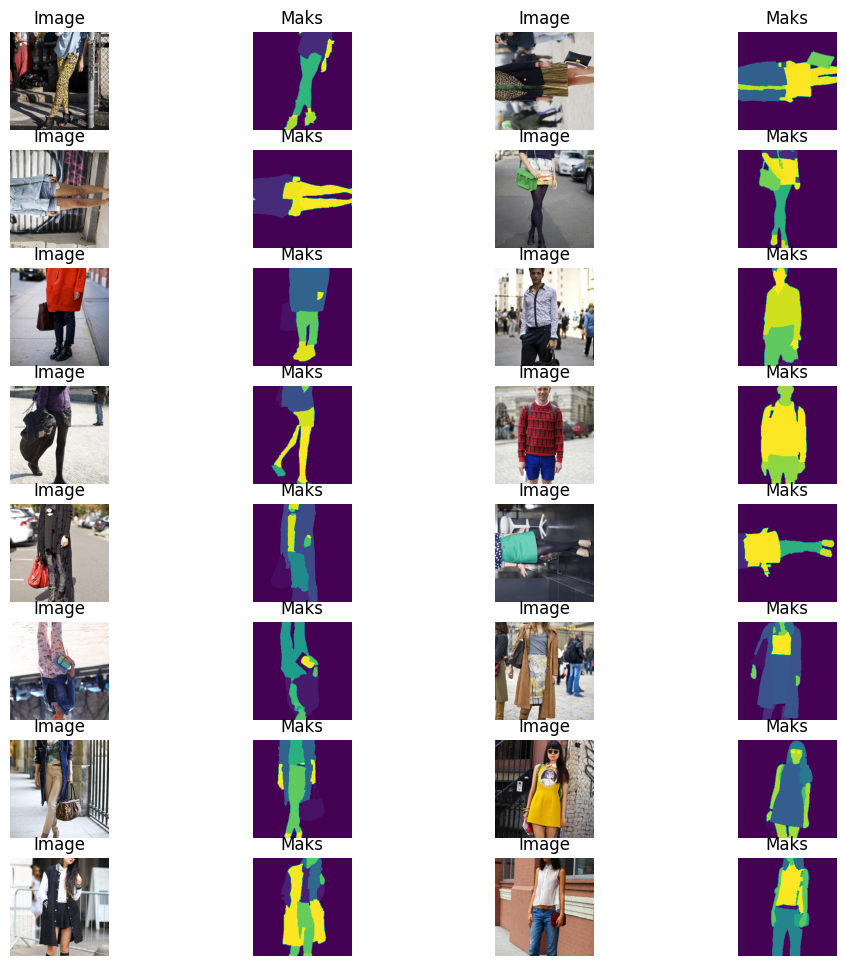

In [ ]:
n_row = 8
n_col = 4
row = 0
col = 0
x_batch = train_dataset.unbatch()
_, ax = plt.subplots(n_row, n_col, figsize=(12, 12))
for data in x_batch.batch(16).take(1):
  images = data['pixel_values']
  masks = data['labels']
  for i in range(n_row * n_col):

    if i%2 == 0:
      ax[row, col].imshow(tf.transpose(images[i//2], [1, 2, 0])*STD+MEAN) # C H W : 0 1 2  --> H W C : 1 2 0
      ax[row, col].axis("off")
      ax[row, col].set_title("Image")
    else:
      ax[row, col].imshow(masks[i//2])
      ax[row, col].axis("off")
      ax[row, col].set_title("Maks")

    if col == n_col-1:
      row += 1
      col = 0
    else:
      col += 1


plt.show()

In [ ]:
train_dataset

<_PrefetchDataset element_spec={'pixel_values': TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)}>

### Labels IDs & Names

In [23]:
labels_df = pd.read_csv("/content/dataset/labels.csv")
labels_df.head(10)

,Unnamed: 0,label_list
0,0,NaN
1,1,accessories
2,2,bag
3,3,belt
4,4,blazer
5,5,blouse
6,6,bodysuit
7,7,boots
8,8,bra
9,9,bracelet


In [24]:
id2label = {}
k = 0
for i, j in labels_df.iterrows():
  if i==0:
    id2label[i] = 'nan'
  else:
    id2label[i] = j['label_list']

id2label

{0: 'nan',
 1: 'accessories',
 2: 'bag',
 3: 'belt',
 4: 'blazer',
 5: 'blouse',
 6: 'bodysuit',
 7: 'boots',
 8: 'bra',
 9: 'bracelet',
 10: 'cape',
 11: 'cardigan',
 12: 'clogs',
 13: 'coat',
 14: 'dress',
 15: 'earrings',
 16: 'flats',
 17: 'glasses',
 18: 'gloves',
 19: 'hair',
 20: 'hat',
 21: 'heels',
 22: 'hoodie',
 23: 'intimate',
 24: 'jacket',
 25: 'jeans',
 26: 'jumper',
 27: 'leggings',
 28: 'loafers',
 29: 'necklace',
 30: 'panties',
 31: 'pants',
 32: 'pumps',
 33: 'purse',
 34: 'ring',
 35: 'romper',
 36: 'sandals',
 37: 'scarf',
 38: 'shirt',
 39: 'shoes',
 40: 'shorts',
 41: 'skin',
 42: 'skirt',
 43: 'sneakers',
 44: 'socks',
 45: 'stockings',
 46: 'suit',
 47: 'sunglasses',
 48: 'sweater',
 49: 'sweatshirt',
 50: 'swimwear',
 51: 't-shirt',
 52: 'tie',
 53: 'tights',
 54: 'top',
 55: 'vest',
 56: 'wallet',
 57: 'watch',
 58: 'wedges'}

In [25]:
label2id = {j:i for i, j in id2label.items()}
label2id

{'nan': 0,
 'accessories': 1,
 'bag': 2,
 'belt': 3,
 'blazer': 4,
 'blouse': 5,
 'bodysuit': 6,
 'boots': 7,
 'bra': 8,
 'bracelet': 9,
 'cape': 10,
 'cardigan': 11,
 'clogs': 12,
 'coat': 13,
 'dress': 14,
 'earrings': 15,
 'flats': 16,
 'glasses': 17,
 'gloves': 18,
 'hair': 19,
 'hat': 20,
 'heels': 21,
 'hoodie': 22,
 'intimate': 23,
 'jacket': 24,
 'jeans': 25,
 'jumper': 26,
 'leggings': 27,
 'loafers': 28,
 'necklace': 29,
 'panties': 30,
 'pants': 31,
 'pumps': 32,
 'purse': 33,
 'ring': 34,
 'romper': 35,
 'sandals': 36,
 'scarf': 37,
 'shirt': 38,
 'shoes': 39,
 'shorts': 40,
 'skin': 41,
 'skirt': 42,
 'sneakers': 43,
 'socks': 44,
 'stockings': 45,
 'suit': 46,
 'sunglasses': 47,
 'sweater': 48,
 'sweatshirt': 49,
 'swimwear': 50,
 't-shirt': 51,
 'tie': 52,
 'tights': 53,
 'top': 54,
 'vest': 55,
 'wallet': 56,
 'watch': 57,
 'wedges': 58}

## Modeling

In [26]:
!pip install -q transformers

In [27]:
from transformers import TFSegformerForSemanticSegmentation

model_id = "nvidia/segformer-b0-finetuned-ade-512-512"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSegformerForSemanticSegmentation: ['decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.bias']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFSegformerForSemanticSegmentation were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.
Some w

In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  410427    
 codeHead)                                                       
                                                                 
Total params: 3729819 (14.23 MB)
Trainable params: 3729307 (14.23 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [28]:
import evaluate
mean_iou = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  # B C H W : 0 1 2 3 --> B H W C : 0 2 3 1
  logits = tf.transpose(logits, [0, 2, 3, 1])
  logits_resized = tf.image.resize(logits,
                                   size=tf.shape(labels)[1:],
                                   method='bilinear'
                                   )
  pred_labels = tf.argmax(logits_resized, axis=-1)
  metrics = mean_iou.compute(
      predictions = pred_labels,
      references = labels,
      num_labels = len(id2label),
      ignore_index = 0
      )

  per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
  per_category_iou = metrics.pop("per_category_iou").tolist()

  metrics.update({f"accuracy_{id2label[i]}":v for i, v in enumerate(per_category_accuracy)})
  metrics.update({f"iou_{id2label[i]}":v for i, v in enumerate(per_category_iou)})

  return {"val"+k : v for k, v in metrics.items()}

In [29]:
from transformers import create_optimizer
optimizer, lr_schedule = create_optimizer(
    init_lr=LR,
    num_train_steps = (len(train_dataset)*EPOCHS),
    weight_decay_rate=WEIGHT_DECAY_RATE,
    num_warmup_steps=0,
)

In [30]:
from transformers.keras_callbacks import KerasMetricCallback
metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_dataset,
    batch_size=BATCH_SIZE,
    label_cols = ['labels']
)
callbacks = [metric_callback]

In [ ]:
model.compile(optimizer=optimizer)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/35
123/123 [==============================] - ETA: 0s - loss: 3.4224

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


123/123 [==============================] - 138s 740ms/step - loss: 3.4224 - val_loss: 3.2745 - valmean_iou: 0.0000e+00 - valmean_accuracy: 0.0000e+00 - valoverall_accuracy: 0.0000e+00 - valaccuracy_nan: 0.0000e+00 - valaccuracy_accessories: nan - valaccuracy_bag: nan - valaccuracy_belt: nan - valaccuracy_blazer: nan - valaccuracy_blouse: nan - valaccuracy_bodysuit: nan - valaccuracy_boots: nan - valaccuracy_bra: nan - valaccuracy_bracelet: nan - valaccuracy_cape: nan - valaccuracy_cardigan: nan - valaccuracy_clogs: nan - valaccuracy_coat: nan - valaccuracy_dress: nan - valaccuracy_earrings: nan - valaccuracy_flats: nan - valaccuracy_glasses: nan - valaccuracy_gloves: nan - valaccuracy_hair: nan - valaccuracy_hat: nan - valaccuracy_heels: nan - valaccuracy_hoodie: nan - valaccuracy_intimate: nan - valaccuracy_jacket: nan - valaccuracy_jeans: nan - valaccuracy_jumper: nan - valaccuracy_leggings: nan - valaccuracy_loafers: nan - valaccuracy_necklace: nan - valaccuracy_panties: nan - valac

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Epoch 2/35
123/123 [==============================] - 73s 586ms/step - loss: 3.3156 - val_loss: 2.9846 - valmean_iou: 0.0000e+00 - valmean_accuracy: 0.0000e+00 - valoverall_accuracy: 0.0000e+00 - valaccuracy_nan: 0.0000e+00 - valaccuracy_accessories: nan - valaccuracy_bag: nan - valaccuracy_belt: nan - valaccuracy_blazer: nan - valaccuracy_blouse: nan - valaccuracy_bodysuit: nan - valaccuracy_boots: nan - valaccuracy_bra: nan - valaccuracy_bracelet: nan - valaccuracy_cape: nan - valaccuracy_cardigan: nan - valaccuracy_clogs: nan - valaccuracy_coat: nan - valaccuracy_dress: nan - valaccuracy_earrings: nan - valaccuracy_flats: nan - valaccuracy_glasses: nan - valaccuracy_gloves: nan - valaccuracy_hair: nan - valaccuracy_hat: nan - valaccuracy_heels: nan - valaccuracy_hoodie: nan - valaccuracy_intimate: nan - valaccuracy_jacket: nan - valaccuracy_jeans: nan - valaccuracy_jumper: nan - valaccuracy_leggings: nan - valaccuracy_loafers: nan - valaccuracy_necklace: nan - valaccuracy_panties: n

Testing

In [28]:
model_path = "/content/drive/MyDrive/dl_models/segFormer"

In [ ]:
# model.save_pretrained(model_path)

In [29]:
# load the segFormer model

loaded_model = TFSegformerForSemanticSegmentation.from_pretrained(model_path)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at /content/drive/MyDrive/dl_models/segFormer.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [54]:
x_batch_1 = next(iter(train_dataset))
x_batch_1['pixel_values'][0].shape

TensorShape([3, 512, 512])

In [65]:
# Test Out one element
preds = model.predict(tf.expand_dims(x_batch_1['pixel_values'][3], axis=0))
preds = preds.logits

1/1 [==============================] - 3s 3s/step


In [66]:
preds_class = tf.argmax(preds, axis=1)
preds_class.shape

TensorShape([1, 128, 128])

In [67]:
mask = tf.squeeze(tf.image.resize(tf.expand_dims(preds_class, axis=-1), (W, H), method='bilinear'), axis=-1)
mask.shape

TensorShape([1, 512, 512])

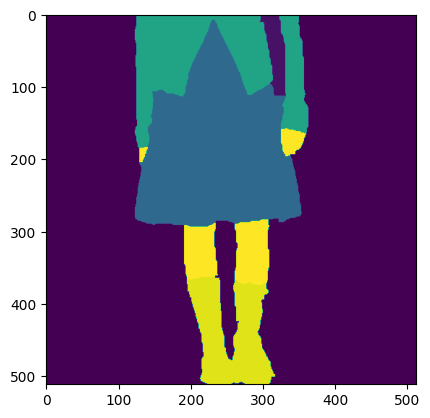

In [68]:
plt.imshow(x_batch_1['labels'][3])

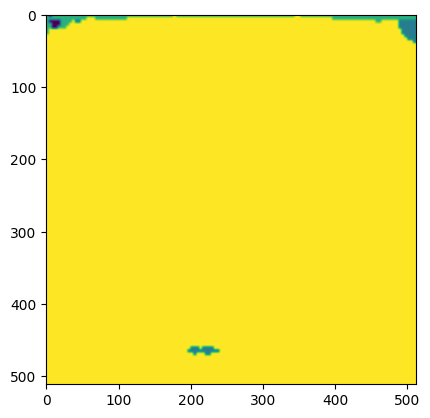

In [69]:
plt.imshow(tf.transpose(mask, [1, 2, 0]))

In [45]:
loaded_model.summary()

Model: "tf_segformer_for_semantic_segmentation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  410427    
 codeHead)                                                       
                                                                 
Total params: 3729819 (14.23 MB)
Trainable params: 3729307 (14.23 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [ ]:
preds = loaded_model.predict(tf.expand_dims(x_batch_1['pixel_values'][0], axis=0))
preds

1/1 [==============================] - 4s 4s/step


TFSemanticSegmenterOutput(loss=None, logits=array([[[[ 0.42376179,  0.30337664,  0.16219473, ..., -0.2718548 ,
          -0.2937654 ,  0.0148756 ],
         [ 0.45726144,  0.32404667,  0.19672392, ..., -0.3319514 ,
          -0.3263114 , -0.30511966],
         [ 0.28400287,  0.18274601,  0.0821209 , ..., -0.32698652,
          -0.32460776, -0.26826137],
         ...,
         [ 0.1888483 , -0.01655715, -0.04028412, ...,  0.03250379,
           0.01686089,  0.01675012],
         [ 0.21522175, -0.02750574, -0.05550734, ..., -0.02522676,
          -0.03117185, -0.02375525],
         [ 0.47106534, -0.00117224,  0.02258326, ...,  0.02195257,
           0.0075501 ,  0.01807817]],

        [[-0.5618119 , -0.5060842 , -0.43788558, ..., -0.2804319 ,
          -0.31915402, -0.308849  ],
         [-0.4525261 , -0.37298027, -0.3348905 , ..., -0.22814938,
          -0.2681368 , -0.21765304],
         [-0.26478684, -0.24822588, -0.17358997, ...,  0.02769473,
           0.01446019,  0.03458821],
    